# Comparación de dos muestras normales #

Leemos la base de datos y definimos las estadísticas suficientes (que obtenemos a través del Teorema de Factorización de Fisher)

In [23]:
####Estadisticas Suficientes####
Mtable<-read.table('Mujeres.txt',header=F)
Htable<-read.table('Hombres.txt',header=F)
M=Mtable$V1; H=Htable$V1
t1=sum(M); t2=sum(M^2); t3=sum(H); t4=sum(H^2)
n=length(M); m=length(H)

Las funciones siguientes son los estimadores de máxima verosimilitud de $\mu$ y $\sigma$ en el caso normal.

In [24]:
####Funciones utiles####
#Obtenemos Hx
getHx<-function(t1, t2, n){
  Hx = t2 - (t1^2/n)
  return(Hx)
}
#Obtenemos el emv de mu
getMuG<-function(t1,n){
  muG = t1/n
  return(muG)
}
#Obtenemos el emv de sigma
getSigmaG<-function(t1,t2,n){
  Hx=getHx(t1,t2,n)
  sigmaG = sqrt(Hx/n)
  return(sigmaG)
}

Definimos $\delta=\mu_2-\mu_1$ y $\rho=\sigma_2/\sigma_1$. Los estimadores de máxima verosimilitud son 

In [25]:
#EMV de rho
getRoG<-function(t1,t2,n,t3,t4,m){
  roG = getSigmaG(t3,t4,m)/getSigmaG(t1,t2,n)
  return(roG)
}
#EMV de delta
getDeltaG<-function(t1,n,t3,m){
  muG = getMuG(t3,m) - getMuG(t1,n)
  return(muG)
}

Calculamos la logverosimilitud perfil de $\delta$.

In [26]:
#B
getB<-function(t1, t2, n, t3, t4, m){
  Hx = getHx(t1, t2, n)
  Hy = getHx(t3, t4, m)
  B  = Hx/(n*(n - 1)) + Hy/(m*(m - 1))
  return(B) 
}
#V
getV<-function(t1, t2, n, t3, t4, m){
  B  = getB(t1, t2, n, t3, t4, m)
  Hx = getHx(t1, t2, n)
  Hy = getHx(t3, t4, m)
  v  = floor(B^2 * ( Hx^2 / (n^2*(n - 1)^3) + Hy^2 / (m^2*(m - 1)^3) )^(-1) )
  return(v)
}
#Log verosimilitud perfil de delta
rDelta<-function(delta, t1, t2, t3, t4, deltaG, v, B){
  r = -((v + 1)/2)*log(1 + (deltaG - delta)^2/(v*B))
  return(r)
}

Calculamos los intervalos de confianza de delta y el nivel asociado a cierta probabilidad utilizando una cantidad pivotal con distribución $t$-Student.

In [27]:
#Nivel c de delta asociado a una probabilidad de cobertura
NivelCDelta<-function(p,v){
  faux<-function(c){
    value<-pt(sqrt(v*(c^(-2/(v+1))-1)),v)-pt(-sqrt(v*(c^(-2/(v+1))-1)),v)-p
  }
  c=uniroot(f=faux,interval=c(0,1))
  return(c$root)
}

#IV de nivel c de delta
getIVDeltaC<-function(c, v, B, deltaG){
  delta1 = deltaG - sqrt(v*B*(c^(-2/(v + 1)) - 1))
  delta2 = deltaG + sqrt(v*B*(c^(-2/(v + 1)) - 1))
  IV     = c(delta1, delta2)
  return(IV)
}

Después, hacemos lo propio para $\rho$.

In [28]:
#Log verosimlitud perfil de rho
rRho<-function(rho,t1,t2,n,t3,t4,m,rhoG){
  Hx=getHx(t1,t2,n)
  Hy=getHx(t3,t4,m)
  r=n*log(rho/rhoG)-(((n+m)/2)*log((rho^2*Hx+Hy)/(rhoG^2*Hx+Hy)))
  return(r)
}
#Probabilidad de cobertura asociada a una nivel c de rho
PCoberturaRho<-function(c){
  interval_asociado_C<-function(c){
    rhoG=getRoG(t1,t2,n,t3,t4,m)
    log_ver_exp<-function(rho,t1,t2,n,t3,t4,m,rhoG){
      Hx=getHx(t1,t2,n)
      Hy=getHx(t3,t4,m)
      r=n*log(rho/rhoG)-(((n+m)/2)*log((rho^2*Hx+Hy)/(rhoG^2*Hx+Hy)))
      return(r)
    }
    Raux<-function(rho){
      return(exp(log_ver_exp(rho,t1,t2,n,t3,t4,m,rhoG)) - c)
    }
    r1 = uniroot(f = Raux, interval = c(max(rhoG - 10, 0), rhoG))
    r2 = uniroot(f = Raux, interval = c(rhoG, rhoG + 10))
    return(c(r1$root, r2$root))
  }
  IVRho=interval_asociado_C(c)
  getA<-function(t1,t2,n,t3,t4,m){
    Hx=getHx(t1,t2,n)
    Hy=getHx(t3,t4,m)
    A=((m-1)*Hx)/((n-1)*Hy)
    return(A)
  }
  A=getA(t1,t2,n,t3,t4,m)
  #Probabiilidad de cobertura
  pcobertura<-pf(A*IVRho[2]^2,n-1,m-1)-pf(A*IVRho[1]^2,n-1,m-1)
  return(pcobertura)
}
#Calcula el intervalo perfil de rho dado el nivel
getIVRhoC<-function(c){
  rhoG=getRoG(t1,t2,n,t3,t4,m)
  log_ver_exp<-function(rho,t1,t2,n,t3,t4,m,rhoG){
    Hx=getHx(t1,t2,n)
    Hy=getHx(t3,t4,m)
    r=n*log(rho/rhoG)-(((n+m)/2)*log((rho^2*Hx+Hy)/(rhoG^2*Hx+Hy)))
    return(r)
  }
  Raux<-function(rho){
    return(exp(log_ver_exp(rho,t1,t2,n,t3,t4,m,rhoG)) - c)
  }
  r1 = uniroot(f = Raux, interval = c(max(rhoG - 10, 0), rhoG))
  r2 = uniroot(f = Raux, interval = c(rhoG, rhoG + 10))
  return(c(r1$root, r2$root))
}

Ahora definimos la logverosimilitud de $\delta$ y $\rho$ que es $l(\delta,\rho)$.

In [29]:
#Logverosimilitud de delta y rho
l<-function(t1,t2,n,t3,t4,m,delta,rho){
  Hx=getHx(t1,t2,n); Hy=getHx(t3,t4,m)
  rhoG=getRoG(t1,t2,n,t3,t4,m); deltaG=getDeltaG(t1,n,t3,m)
  value=n*log(rho)-((n+m)/2)*log(rho^2*Hx+Hy)-((n+m)/2)*log(1+(n*m*(deltaG-delta)^2)/((rho^2*n+m)*(Hx+Hy/rho^2)))
  return(value)
}

La siguiente función define los contornos de nivel de la verosimlitud conjunta.

In [30]:
#Funcion que grafica contornos de nivel de la verosimilitud conjunta de rho y delta
plotRelative<-function(t1,t2,n,t3,t4,m,l, aG, bG, xL, xR, yL, yR, levels,
                       N, xlab="",
                       ylab="", main=""){
  x_vec = seq(from = xL, to = xR, length.out = N)
  y_vec = seq(from = yL, to = yR, length.out = N)
  R<-function(a, b){
    return(exp(l(t1,t2,n,t3,t4,m,a,b)-l(t1,t2,n,t3,t4,m,aG,bG)))
  }
  Rmat = matrix(nrow = N, ncol = N)
  
  for(i in 1:N){
    for(j in 1:N){
      Rmat[i, j] = R(x_vec[i], y_vec[j])
    }
  }
  contour(x_vec,y_vec,Rmat,level=levels,xlab=xlab,ylab=ylab,main=main)
}

Haremos una prueba que se basará en el pivotal de Sprott-Farewell para determinar la igualdad si hay evidencia a favor de la igualdad de medias.

In [31]:
#Criterio de Robusticidad
Drho<-function(t1,t2,n,t3,t4,m,rho){
  Hx<-getHx(t1,t2,n); Hy<-getHx(t3,t4,m)
  D<-((rho^2*n+m)/(n*m*(n+m-2)))*(Hx+Hy/rho^2)
  return(D)
}
IVTsfDelta<-function(t1,t2,n,t3,t4,m,rho){
  Dp<-Drho(t1,t2,n,t3,t4,m,rho)
  q=qt(0.05/2,n+m-2)
  deltaG=getDeltaG(t1,n,t3,m)
  r1=deltaG+q*sqrt(Dp)
  r2=deltaG-q*sqrt(Dp)
  return(c(r1,r2))
}

Ahora lo que haremos determinar la trayectoria de $\rho$ respecto a un valor de $\delta$, es decir, maximizamos la logverosimilitud conjunta respecto a $\rho$ dado $\delta$.

In [10]:
#Trayectoria rho
Trho<-function(delta){
  Raux<-function(rho){
    R=l(t1,t2,n,t3,t4,m,delta,rho)
    return(R)
  }
  rhoG<-getRoG(t1,t2,n,t3,t4,m)
  interval<-c(0.01,2.5)
  maximo=optimize(Raux,interval,maximum = TRUE)
  return(maximo$maximum)
}

Graficamos la verosimilitud perfil de $\mu_1$ y $\mu_2$, para analizar como se comporta la estimación de la media cada población.

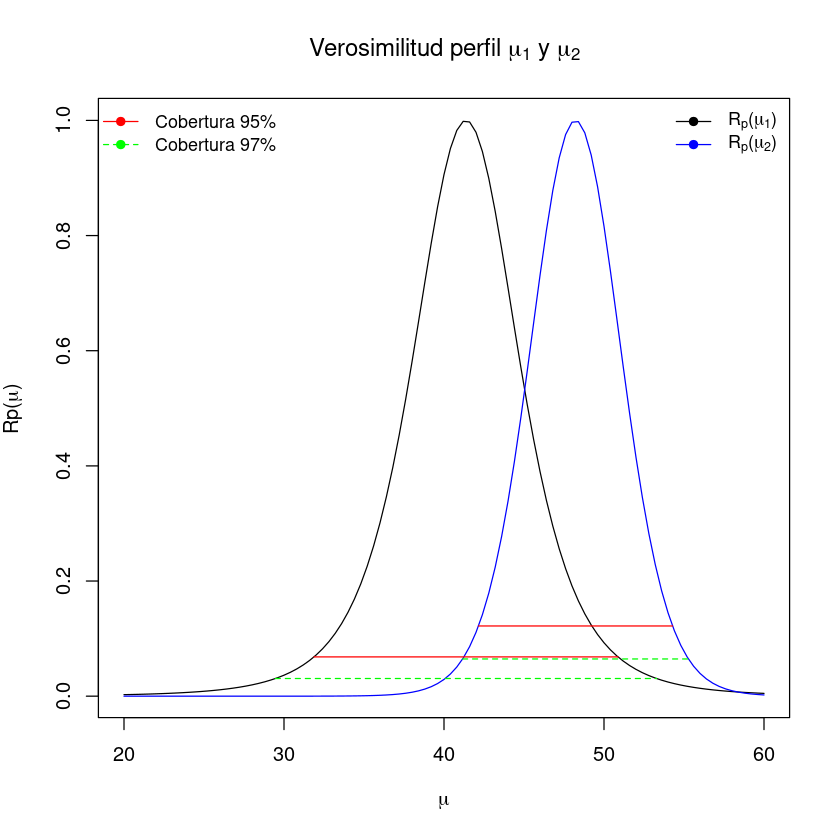

In [32]:
####Verosimilitud Perfil de mu1 y mu2####
#Probabilidades de Cobertura Deseada
alpha=0.05; beta=1-sqrt(0.95)
#Cobertura 0.95
q1<-qt(alpha/2,n-1); q2<-qt(alpha/2,m-1)
#Cobertura sqrt(0,95)
q3<-qt(beta/2,n-1); q4<-qt(beta/2,m-1)
#Niveles de verosimilitud
NivelCProb95_1=((q1^2/(n-1))+1)^(-n/2); NivelCProb95_2=((q2^2/(m-1))+1)^(-m/2)
NivelCProbs95_1=((q3^2/(n-1))+1)^(-n/2); NivelCProbs95_2=((q4^2/(m-1))+1)^(-m/2)
#Calcular el IV para cada muestra de los niveles anteriores
#Definimos la funcion que nos da el intervalo
getIVmu<-function(c,t1,t2,n){
  thetaG = t1/n
  log_ver_exp<-function(x){
    H=t2-(t1^2/n)
    value=-(n/2)*log((H/n)+(t1/n-x)^2)-n/2
    return(value)
  }
  Raux<-function(x){
    return(exp(log_ver_exp(x) - log_ver_exp(thetaG)) - c)
  }
  r1 = uniroot(f = Raux, interval = c(max(thetaG - 100, 0), thetaG))
  r2 = uniroot(f = Raux, interval = c(thetaG, thetaG + 100))
  return(c(r1$root, r2$root))
}
#Calculamos ambos intervalos
IVmu195<-getIVmu(NivelCProb95_1,t1,t2,n)
IVmu295<-getIVmu(NivelCProb95_2,t3,t4,m)
IVmu1s95<-getIVmu(NivelCProbs95_1,t1,t2,n)
IVmu2s95<-getIVmu(NivelCProbs95_2,t3,t4,m)  
#logverosimilitud perfil mu
l1<-function(x,t1,t2,n){
  H=t2-(t1^2/n)
  value=-(n/2)*log((H/n)+(t1/n-x)^2)-n/2
  return(value)
}
#Definimos la verosimilitud relativa de mu
R1<-function(x,t1,t2,n){
  value<-exp(l1(x,t1,t2,n)-l1(t1/n,t1,t2,n))
  return(value)
}
#Graficamos ambas verosimlitudes
curve(R1(x,t1,t2,n),20,60,xlab=expression(paste(mu)),
      ylab=expression(paste("Rp(",mu,")")),
      main=expression(paste("Verosimilitud perfil ",mu,""[1]," y ",mu,""[2])))
curve(R1(x,t3,t4,m),20,60,add=TRUE,col="blue")
#Ahora ponemos los intervalos de verosimlitud
segments(IVmu195[1],R1(IVmu195[1],t1,t2,n),
         IVmu195[2],R1(IVmu195[2],t1,t2,n),col="red")
segments(IVmu295[1],R1(IVmu295[1],t3,t4,m),
         IVmu295[2],R1(IVmu295[2],t3,t4,m),col="red")
segments(IVmu1s95[1],R1(IVmu1s95[1],t1,t2,n),
         IVmu1s95[2],R1(IVmu1s95[2],t1,t2,n),col="green",lty=2)
segments(IVmu2s95[1],R1(IVmu2s95[1],t3,t4,m),
         IVmu2s95[2],R1(IVmu2s95[2],t3,t4,m),col="green",lty=2)
#Leyendas
legend("topright",legend=c(expression(paste("R",""[p],"(",mu,""[1],")")),
                           expression(paste("R",""[p],"(",mu,""[2],")"))),
       col=c("black","blue"),lty=1:1,pch=19:19,cex=0.9,bty="n")
legend("topleft",legend=c("Cobertura 95%","Cobertura 97%"),col=c("red","green"),
       lty=1:2,pch=19:19,cex=0.9,bty="n")

Hacemos lo propio con $\sigma_1$ y $\sigma_2$

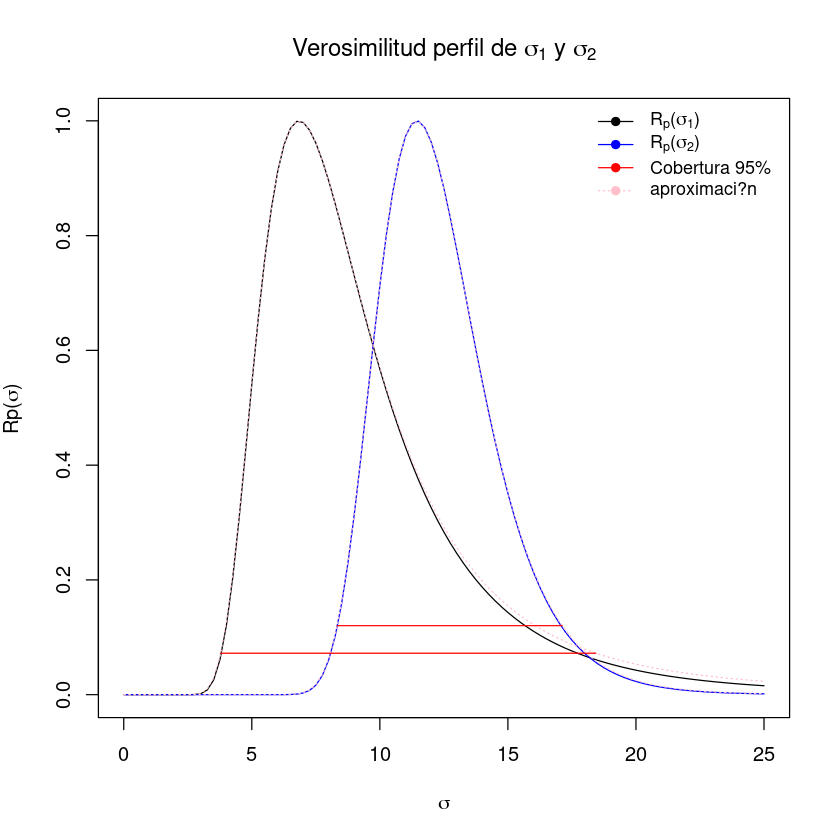

In [33]:
####Verosimilitud Perfil de sigma1 y sigma2####
#Obtenemos numericamente el nivel
f<-function(c,n){
  value<-pchisq(n*(1+(1/3)*sqrt((-4*log(c))/n))^(3),n-1)-pchisq(n*(1-(1/3)*sqrt((-4*log(c))/n))^(3),n-1)
  return(value)
}
# Que sera justo los extremos del intervalo de verosimilitud de nivel c.
NivelCSigma<-function(p,n){
  Faux<-function(c){
    return(f(c,n) - p)
  }
  r1 = uniroot(f = Faux, interval = c(0.01, 0.5))
  return(r1$root)
}
NivelSigma1<-NivelCSigma(0.95,n)
NivelSigma2<-NivelCSigma(0.95,m)
#Ahora obtenemos los intervalos
interval_sigma<-function(c,t1,t2,n){
  sigmaG=getSigmaG(t1,t2,n)
  r1=sigmaG*((1+(1/3)*sqrt(-4*log(c)/n))^(-3/2))
  r2=sigmaG*((1-(1/3)*sqrt(-4*log(c)/n))^(-3/2))
  return(c(r1,r2))
}
IVsigma1<-interval_sigma(NivelSigma1,t1,t2,n) 
IVsigma2<-interval_sigma(NivelSigma2,t3,t4,m)
#Definimos la logverosimilitud perfil de sigma
l2<-function(x,t1,t2,n){
  H=t2-(t1^2/n)
  value=-n*log(x)-H/(2*x^2)
  return(value)
}
#Definimos las verosimilitud perfil relativa de sigma
R2<-function(x,t1,t2,n){
  H=t2-(t1^2/n)
  value=exp(l2(x,t1,t2,n)-l2(sqrt(H/n),t1,t2,n))
  return(value)
}
R2aprox<-function(x,t1,t2,n){
  sigmaG=getSigmaG(t1,t2,n)
  value=exp((-9*n/4)*((1-(sigmaG/x)^(2/3))^2))
  return(value)
}
#Graficamos ambas verosimlitudes
curve(R2(x,t1,t2,n),0.01,25,xlab=expression(paste(sigma)),
      ylab=expression(paste("Rp(",sigma,")")),
      main=expression(paste("Verosimilitud perfil de ",sigma,""[1]," y ",sigma,""[2])))
curve(R2(x,t3,t4,m),0.01,25,add=TRUE,col="blue")
curve(R2aprox(x,t1,t2,n),0.01,25,add=TRUE,col="pink",lty=3,lwd=1)
curve(R2aprox(x,t3,t4,m),0.01,25,add=TRUE,col="pink",lty=3,lwd=1)
#Ahora ponemos los intervalos de verosimlitud
segments(IVsigma1[1],R2aprox(IVsigma1[1],t1,t2,n),
         IVsigma1[2],R2aprox(IVsigma1[2],t1,t2,n),col="red")
segments(IVsigma2[1],R2aprox(IVsigma2[1],t3,t4,m),
         IVsigma2[2],R2aprox(IVsigma2[2],t3,t4,m),col="red")
#Leyendas
legend("topright",legend =c(expression(paste("R",""[p],"(",sigma,""[1],")")),
                            expression(paste("R",""[p],"(",sigma,""[2],")")),
                            "Cobertura 95%","aproximaci?n"),lty = c(1,1,1,3),
       col=c("black","blue","red","pink"),pch = c(19,19,19,19),cex=0.9,bty="n")


A continuación mostramos la verosimilitu perfil de $\delta$.

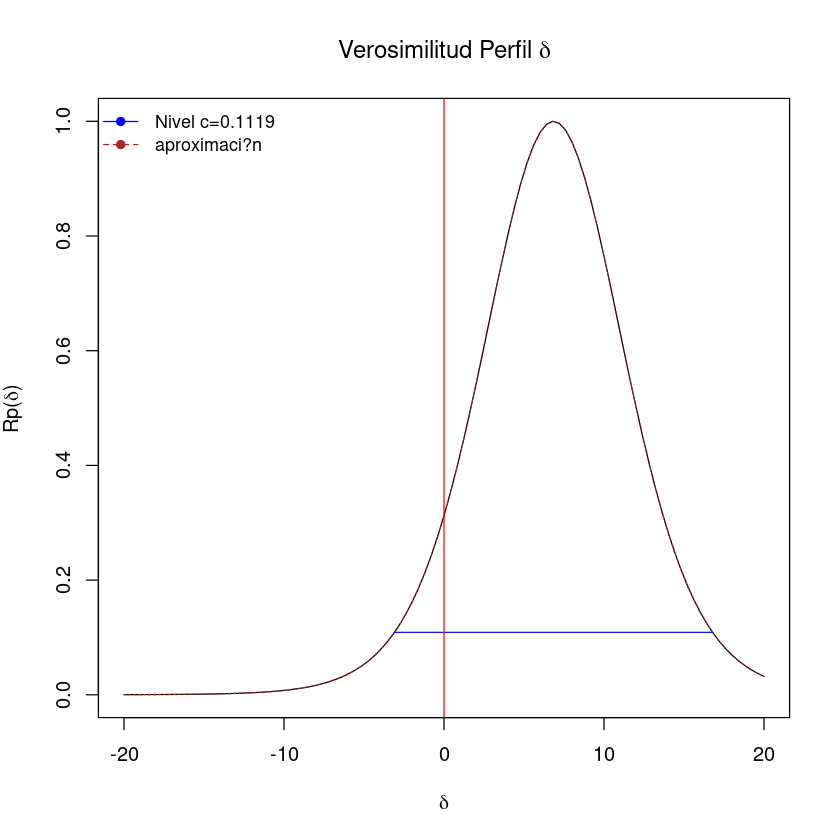

In [34]:
####Verosimilitud Perfil de delta e IV####
deltaG = getDeltaG(t1,n,t3,m)
B      = getB(t1, t2, n, t3, t4, m)
v      = getV(t1, t2, n, t3, t4, m)
c      = NivelCDelta(0.95,v)

RDeltaAux<-function(delta){
  R = exp( rDelta(delta, t1, t2, t3, t4, deltaG, v, B) )
  return(R)
}
constantC<-function(delta){
  vals = c()
  for(i in 1:length(delta)){
    vals[i] = c
  }
  return(vals)
}
RDeltaAprox<-function(delta){
  R=exp((-(v+1)/2)*log(1+((deltaG-delta)^2/(v*B))))
  return(R)
}
IVdeltac = getIVDeltaC(c, v, B, deltaG)
curve(RDeltaAux, from = -20, to = 20, col = "black",
      main=expression(paste("Verosimilitud Perfil ",delta)),
      xlab=expression(paste(delta)),
      ylab=expression(paste("Rp(",delta,")")))
curve(RDeltaAprox,from=-20,to=20,col="brown",lty=3,add=T)
curve(constantC, from = IVdeltac[1], to = IVdeltac[2], col = "blue", add = TRUE)
abline(v=0,col="red")
legend("topleft",legend=c("Nivel c=0.1119","aproximaci?n"),col=c("blue","brown"),lty=1:3,
       cex=0.9,pch=19:19,bty="n")

Y la de $\rho$

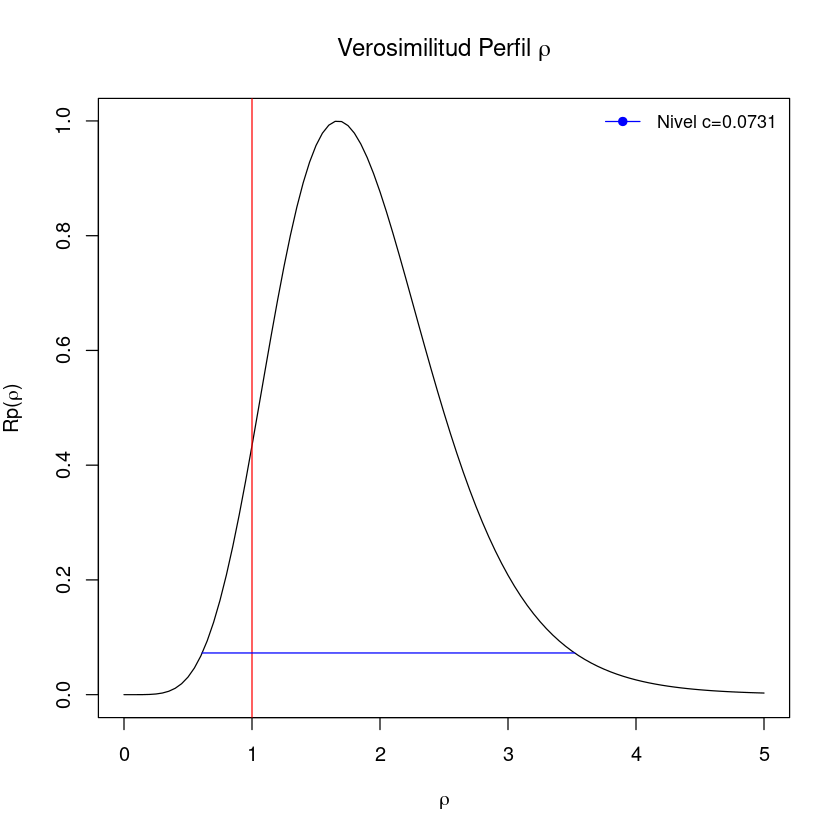

In [35]:
####Verosimilitud Perfil de rho e IV####
rhoG=getRoG(t1,t2,n,t3,t4,m)
RrhoAux<-function(rho){
  R=exp(rRho(rho,t1,t2,n,t3,t4,m,rhoG))
  return(R)
}
curve(RrhoAux, from = 0, to = 5, col = "black",
      main=expression(paste("Verosimilitud Perfil ",rho)),
      xlab=expression(paste(rho)),
      ylab=expression(paste("Rp(",rho,")")))
abline(v=1,col="red")
#Graficamos y calculamos el IV perfil de rho
faux<-function(c){
  return(PCoberturaRho(c)-0.95)
}
nivelC=uniroot(f=faux,interval=c(0.01,1))
IVrhoc=getIVRhoC(nivelC$root)
segments(IVrhoc[1],RrhoAux(IVrhoc[1]),IVrhoc[2],RrhoAux(IVrhoc[2]),col="blue")
legend("topright",legend = c("Nivel c=0.0731"),col=c("blue"),cex=0.9,bty="n",
       lty=1,pch=19)

Mostramos los contornos de nivel de $\mu$ y $\sigma$ 

Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning message in log(sigma):
“Se han producido NaNs”
Warning me

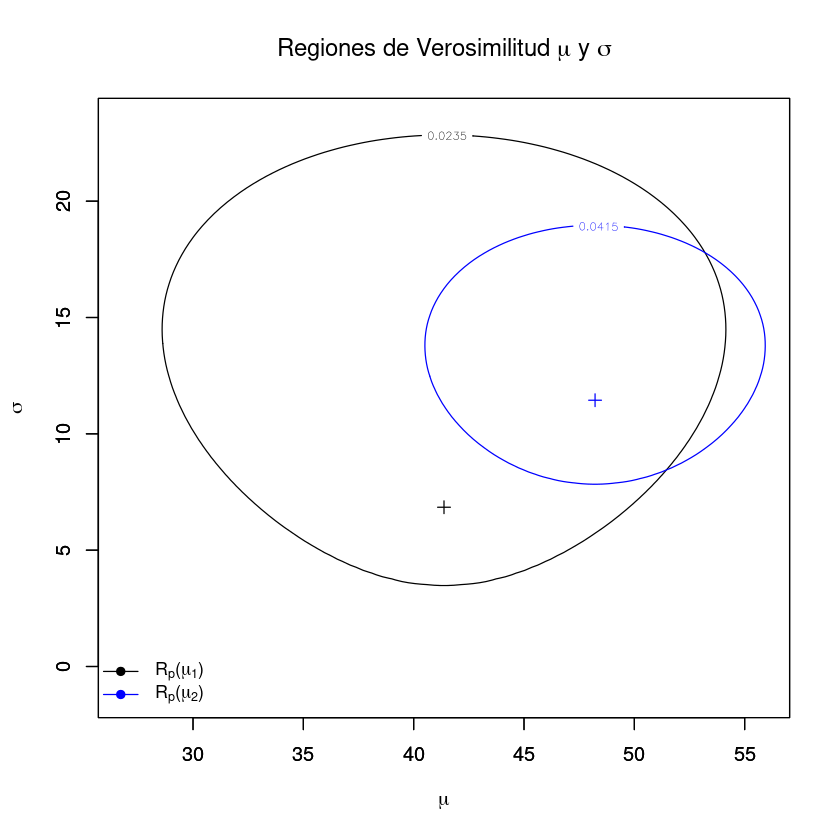

In [36]:
####Contornos de mu y sigma####
#Definimos la logverosimilitud
lmusigma<-function(t1,t2,n,mu,sigma){
  value<--n*log(sigma)-(1/(2*sigma^2))*(t2-2*mu*t1+n*mu^2)
  return(value)
}
#Se define la funcion para graficar este contorno
plotRelative1<-function(t1,t2,n,l, muG, sigmaG, xL, xR, yL, yR, levels, m, xlab="",
                       ylab="", main="",xlim=c(),ylim=c(),col=""){
  x_vec = seq(from = xL, to = xR, length.out = m)
  y_vec = seq(from = yL, to = yR, length.out = m)
  
  R<-function(mu, sigma){
    return(exp(l(t1,t2,n, mu, sigma) - l(t1,t2,n, muG, sigmaG)))
  }
  
  Rmat = matrix(nrow = m, ncol = m)
  
  for(i in 1:m){
    for(j in 1:m){
      Rmat[i, j] = R(x_vec[i], y_vec[j])
    }
  }
  
  contour(x_vec,y_vec,Rmat,level=levels,xlab=xlab,ylab=ylab,main=main,xlim=xlim,
          ylim=ylim,col=col)
}
#Region de graficacion
xL1=IVmu195[1]-5; xR1=IVmu195[2]+5; yL1=IVsigma1[1]-5; yR1=IVsigma1[2]+5;
levels1=c(0.0235)
xL2=IVmu295[1]-5; xR2=IVmu295[2]+5; yL2=IVsigma2[1]-5; yR2=IVsigma2[2]+5;
levels2=c(0.0415)
muG1=getMuG(t1,n); muG2=getMuG(t3,m)
sigmaG1=getSigmaG(t1,t2,n); sigmaG2=getSigmaG(t3,t4,m)
#Se grafican los contornos de cada muestra
plotRelative1(t1,t2,n,lmusigma,muG1,sigmaG1,xL1,xR1,yL1,yR1,levels1,100,
             xlab=expression(paste(mu)),
             ylab = expression(paste(sigma)),
             main=expression(paste("Regiones de Verosimilitud ",mu," y ",sigma)),
             xlim=c(xL1,xR1),ylim=c(yL1,yR1),col="black")
par(new=TRUE)
plotRelative1(t3,t4,m,lmusigma,muG2,sigmaG2,xL2,xR2,yL2,yR2,levels2,100,
              xlim=c(xL1,xR1),ylim=c(yL1,yR1),col="blue")
points(muG1,sigmaG1,pch=3,col="black")
points(muG2,sigmaG2,pch=3,col="blue")
legend("bottomleft",legend=c(expression(paste("R",""[p],"(",mu,""[1],")")),
                           expression(paste("R",""[p],"(",mu,""[2],")"))),
       col=c("black","blue"),lty=1:1,pch=19:19,cex=0.9,bty="n")

A continuación mostramos los contornos de nivel de $\delta$ y $\rho$

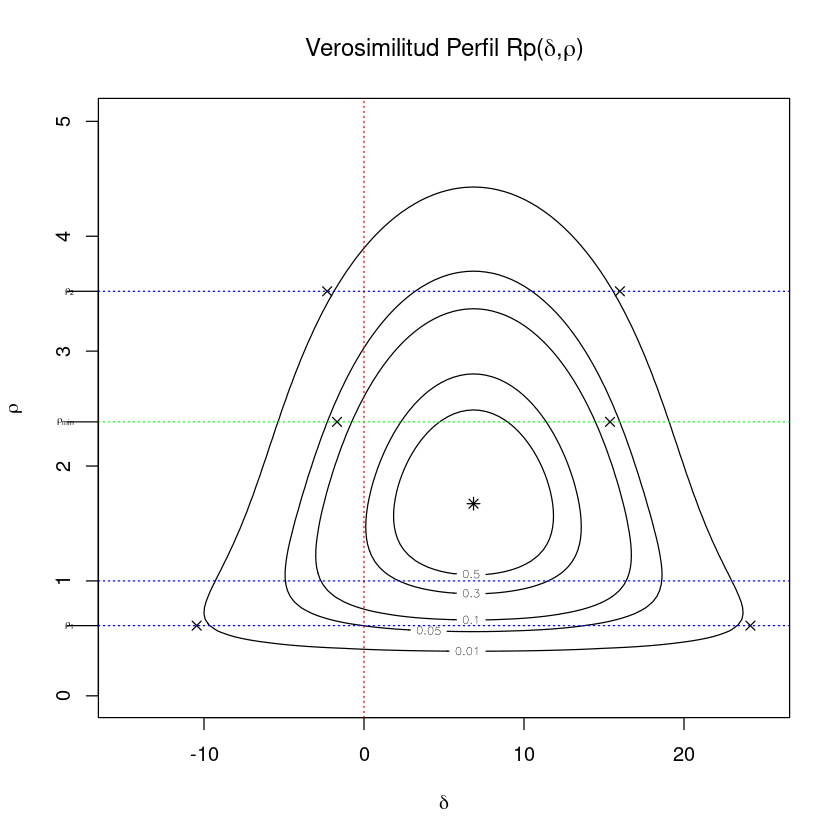

In [37]:
####Contornos de delta y rho####
levels<-c(1:5)
levels[1]=0.5; levels[2]=0.3; levels[3]=0.1; levels[4]=0.05
levels[5]=0.01
xL=-15; xR=25; yL=0.01; yR=5
N=100
plotRelative(t1,t2,n,t3,t4,m,l, deltaG, rhoG, xL, xR, yL, yR, levels,
             N,
             main=expression(paste("Verosimilitud Perfil ","Rp(",delta,",",rho,")")),
             xlab=expression(paste(delta)),
             ylab=expression(paste(rho)))
points(deltaG,rhoG,pch=8)
####IV de rho,rhomin ,delta=0,rho=1####
abline(v=0,lty=3,col="red"); abline(h=1,lty=3,col="blue"); abline(h=IVrhoc[1],lty=3,col="blue")
abline(h=IVrhoc[2],lty=3,col="blue")
rhomin=sqrt((rhoG*m)/n)
abline(h=rhomin,lty=3,col="green")
legendRhos<-c(IVrhoc[1],rhomin,IVrhoc[2])
axis(2,at=legendRhos,labels =c(expression(paste(rho,""[1])),expression(paste(rho,""[min])),expression(paste(rho,""[2]))) ,
     las=2,cex.axis=0.5,tck=-0.05,col.axis="black")
####Criterio de robusticidad####
IVRob1<-IVTsfDelta(t1,t2,n,t3,t4,m,IVrhoc[1])
IVRob2<-IVTsfDelta(t1,t2,n,t3,t4,m,IVrhoc[2])
IVRob3<-IVTsfDelta(t1,t2,n,t3,t4,m,rhomin)
points(IVRob1[1],IVrhoc[1],pch=4,col="black"); points(IVRob1[2],IVrhoc[1],pch=4,col="black")
points(IVRob2[1],IVrhoc[2],pch=4,col="black"); points(IVRob2[2],IVrhoc[2],pch=4,col="black")
points(IVRob3[1],rhomin,pch=4,col="black"); points(IVRob3[2],rhomin,pch=4,col="black")


Ahora como a partir de aquí podemos ver que hay evidencia a favor de la igualdad de medias visualizamos también los contornos de nivel de $\mu_1$ y $\mu_2$

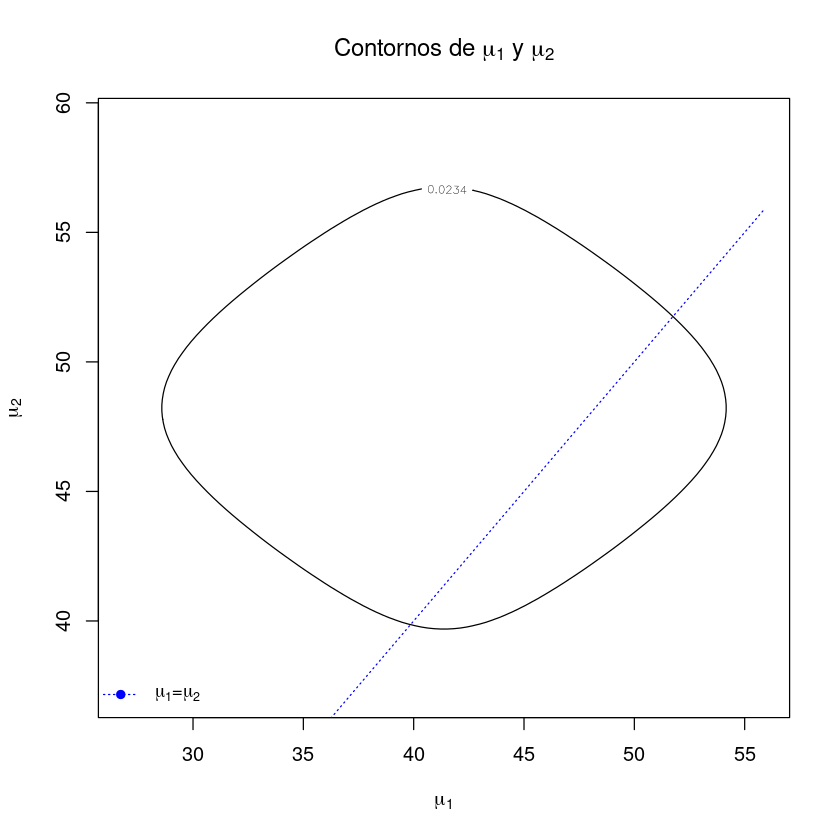

In [19]:
####Contornos mu1 y mu2####
lmu1mu2<-function(t1,t2,n,t3,t4,m,mu1,mu2){
  l=l1(mu1,t1,t2,n)+l1(mu2,t3,t4,m)
  return(l)
}
levels=c(0.0234)
plotRelative(t1,t2,n,t3,t4,m,lmu1mu2, muG1, muG2, xL1, xR1, xL2, xR2, levels,
                       100, xlab=expression(paste(mu,""[1])),
                       ylab=expression(paste(mu,""[2])),
             main=expression(paste("Contornos de ",mu,""[1]," y ",mu,""[2])))
haux<-function(x){
  return(x)
}
curve(haux,from=xL1,to=xR1,add=T,lty=3,col="blue")
legend("bottomleft",legend = c(expression(paste(mu,""[1],"=",mu,""[2]))),
       cex=0.9,pch=19,lty=3,col=c("blue"),bty="n")

Utilizamos también el AIC para comparar los diferentes modelos.

In [22]:
####Comparaci?n con AIC####
#Muestras a comparar
X1=M; X2=H
#Caso 1: Dos normales distintas (4 Parametros)
emvCaso1<-c(muG1,muG2,sigmaG1,sigmaG2)
Aux1=dnorm(X1,muG1,sigmaG1,log=T); Aux2=dnorm(X2,muG2,sigmaG2,log=T)
#print(sum(Aux1)+sum(Aux2))
AIC1<-(-2)*(sum(Aux1)+sum(Aux2))+2*4
#Caso 2: Dos normales con media comun (3 Par?metros)
L2<-function(Z){
  mu=Z[1]; sigma1=Z[2]; sigma2=Z[3]
  Aux1<-dnorm(X1,mu,sigma1,log=T); Aux2<-dnorm(X2,mu,sigma2,log = T)
  value=-(sum(Aux1)+sum(Aux2))
  return(value)
}

#Punto Inicial 2
p0=muG1;  p1=sigmaG1; p2=sigmaG2
pInicial2<-c(p0,p1,p2)
#Optimizacion 2
emvCaso2<-optim(pInicial2,L2,method ="L-BFGS-B",lower=c(0.01,0.01,0.01),
                upper=c(100,100,100))
AIC2<-2*L2(emvCaso2$par)+2*3
#Caso 3: Dos normales con varianza comun (3 Par?metros)#
L3<-function(Z){
  mu1=Z[1]; mu2=Z[2]; sigma1=Z[3]
  Aux1<-dnorm(X1,mu1,sigma1,log=T); Aux2<-dnorm(X2,mu2,sigma1,log=T)
  value=-(sum(Aux1)+sum(Aux2))
  return(value)
}
#Punto Inicial 3
q0=muG1; q1=muG2; q2=sigmaG1
pInicial3<-c(q0,q1,q2)
#Optimizacion 3
emvCaso3<-optim(pInicial3,L3,method = "L-BFGS-B",lower=c(0.01,0.01,0.01),
                upper=c(100,100,100))
AIC3<-2*L3(emvCaso3$par)+2*3
#Caso 4: Una sola normal (2 Par?metros)
L4<-function(Z){
  mu=Z[1]; sigma=Z[2]
  Aux1<-dnorm(X1,mu,sigma,log=T); Aux2<-dnorm(X2,mu,sigma,log=T)
  value=-(sum(Aux1)+sum(Aux2))
  return(value)
}
#Punto Inicial 4
r0=muG1; r1=sigmaG1
pInicial4<-c(r0,r1)
#Optimizaco?n
emvCaso4<-optim(pInicial4,L4,method = "L-BFGS-B",lower=c(0.01,0.01,0.01),
                upper = c(100,100,100))
AIC4<-2*L4(emvCaso4$par)+2*2
print(AIC1)
print(AIC2)
print(AIC3)
print(AIC4)

[1] 172.5442
[1] 173.0272
[1] 172.2132
[1] 171.7752
